In [6]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5,5)

## _Recovering grabled English_:

# Table of contents

1. [part (a), building the markov model](#markov)
2. [parts (c) and (d), the forward algorithm](#forward)
3. [part (b)+(e), testing the Viterbi algorithm](#Viterbi)
4. [part (f), optimal test for seperating garbeled text from random text](#test)



(a) Build a Markov model for the english language using some downloaded book on
the internet. The model should contain the transition probabilities between every
two states, each state consists of one letter (including spaces, commas and stops.
i.e., ”cat says miau” is expressed as ”c”-> ”a” -> ”t” ->” ”-> ”s” ...).[link](#markov)

(b) Pick 10 long english sentences, for each sentence, for every letter (or symbol), with
probability 0.5 replace it with a random letter and with probability 0.5 leave it
intact. **for the implementation, see part(e) where its used**

(c) Write the formula for the likelihood of a sequence of letters given the statistical
model created by applying the garbling process in (b) to outputs of the Markov
model in (a).[link](#forward)

(d) Implement the Forward algorithm. Test that you have calculated the exact likeli-
hood of a short sequence of letters for which you can calculate the likelihood by
brute force. Warning: exponentiating small numbers will cause numerical precision
loss. In the algorithm, when calculating the log of the addition of two exponents
of large negative numbers, take out the smaller negative number as a common
multiplicative. For example:[link](#forward)

log(e−1001 + e−1002) = log(e−1001 (1 + e−1)) = −1001 + log(1 + e−1) .

(e) Implement the Viterbi algorithm. See if you can recover the original sentence from
the scrambled one.[link](#Viterbi)

(f) Write an optimal test for deciding if a given sequence of letters is garbeled english
(with known garbling probability) or a random sequence of letters (same as garbling
of 100%). Vary the garbling probability in the range 1% to 99%, and apply the test
on a text of length 1000 letters with this garbling probability. At what garbling
probability you cannot statistically decide if the text is garbled english or random?
Pick the maximal garbling probability for which the success of this decision process
is > 95%. Apply the Viterbi algoirthm to recover the most likely text on a sample
of garbled english. Does it work?


<a id="markov"></a>

In [7]:
#the states in our markov model:

import string
letters = string.ascii_lowercase+' ,.'

print letters

abcdefghijklmnopqrstuvwxyz ,.


**(a) Build a Markov model for the english language using some downloaded book on the internet. The model should contain the transition probabilities between every two states, each state consists of one letter (including spaces, commas and stops. i.e., ”cat says miau” is expressed as ”c”-> ”a” -> ”t” ->” ”-> ”s” ...).**

In [8]:
# loading some books to calculate letter transition frequency

import unicodedata
import codecs

#all books were downloaded from https://www.gutenberg.org/
f = codecs.open('WarAndPeace.txt', encoding='utf-8')
lines = f.readlines()
f.close()

f = codecs.open('SherlockHolmes.txt', encoding='utf-8')
lines += f.readlines()
f.close()

#not the most elegant way to clean it up, but it works...
lines = [unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').rstrip() for x in lines]
lines = " ".join(lines)
lines = "".join([x.lower() if x.lower() in letters else ' ' for x in lines  ])
lines = ' '.join( lines.split()) #get rid of extra spaces

In [9]:
#some example text
lines[4500000 : 4500000+800]

'strate, on the assassination of his superior in office. the disputed election of . while taking note of the long years of republican supremacy, it must be recorded that grave doubts exist in the minds of many historians as to whether one of the three presidents, hayes, was actually the victor in or not. his democratic opponent, samuel j. tilden, received a popular plurality of a quarter of a million and had a plausible claim to a majority of the electoral vote. at all events, four states sent in double returns, one set for tilden and another for hayes and a deadlock ensued. both parties vehemently claimed the election and the passions ran so high that sober men did not shrink from speaking of civil war again. fortunately, in the end, the counsels of peace prevailed. congress provided for a'

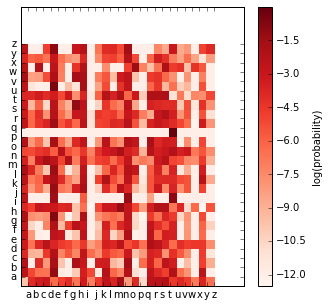

In [10]:
#build the matrix of letter transitions:

transition_dict = {}

#intilise empty dictionary
for firstLetter in letters:
    transition_dict[firstLetter] = {}
    transition_dict[firstLetter]['total']=0   
    for secondLetter in letters:
        transition_dict[firstLetter][secondLetter]=0

#go through the book, count instances of transitions and the total number of times a letter has appeared 
for i,letter in enumerate(lines):
    if i < len(lines)-2:
        transition_dict[letter][lines[i+1]]+=1
        transition_dict[letter]['total']+=1

        
#create a log(p) transition dictionary
transition_dictLog = {}

for letter in letters:
    transition_dictLog[letter] = {}
    for letter2 in letters:
        if transition_dict[letter][letter2] > 0:
            transition_dictLog[letter][letter2] = np.log( transition_dict[letter][letter2] ) - np.log( transition_dict[letter]['total'] )
        else:
            transition_dictLog[letter][letter2] = '-infinity'
            
np.save('dict.npy',transition_dictLog)

#calculate a map of probablities
lettermap = []
for firstLetter in letters:
    if firstLetter in ' .,':
        continue
    lettermap.append([])
   
    for secondLetter in letters:
        if secondLetter in ' .,':
            continue
        lettermap[-1].append(transition_dict[firstLetter][secondLetter])
        #normalize each entry to a probability
        if(lettermap[-1][-1]==0):
            lettermap[-1][-1] = -12.0 #proxy for -infinity
            continue
        lettermap[-1][-1] = np.log( float(lettermap[-1][-1])/float(transition_dict[firstLetter]['total']) )
        
#draw matrix
heatmap = plt.pcolor(lettermap,cmap='Reds')
#heatmap = plt.imshow(lettermap, cmap='Blues', interpolation='none')
plt.colorbar(heatmap,label='log(probability)')
my_xticks = [x for x in string.ascii_lowercase]
x = np.linspace(1,len(string.ascii_lowercase),len(string.ascii_lowercase))
plt.xticks(x, my_xticks)
plt.yticks(x, my_xticks)

plt.show()


(b) Pick 10 long english sentences, for each sentence, for every letter (or symbol), with
probability 0.5 replace it with a random letter and with probability 0.5 leave it
intact. - **I will move this code down next to where we use it, for the Viterbi algorithm**

<a id="forward"></a>

### Forward algorithm

(c) Write the formula for the likelihood of a sequence of letters given the statistical
model created by applying the garbling process in (b) to outputs of the Markov
model in (a).

The probability P( output sentence of length N ) is the sum over all possible sentences of length N of the product of the probability to generate that sentence with the markov model and the probability to get that garbeled sequence from that original sentence

$P_{(Y=\text{output sentence of length N})} = \sum_{X = \text{N letter combinations}} P_{(X|\text{Markov model})}\cdot P_{(Y|X)}$

the probability $P_{(X|\text{Markov model})}$ is the product of transition probablities for the letters in the sequence X

and $P_{(Y|X)}$ is the product of probablities of emitting letter $Y_{i}$ from $X_{i}$ which for a given garbeling probablitiy $p_{garble}$ is:

$P_{(y_{i}|x_{i})}=\begin{cases}
(1-p)+p\cdot1/N & x_{i}=y_{i}\\
p\cdot1/N & x_{i}\neq y_{i}
\end{cases}$

where N is the number of possible characters in our model

(d) Implement the Forward algorithm. Test that you have calculated the exact likelihood of a short sequence of letters for which you can calculate the likelihood by
brute force. 

In [11]:
##the Forward algorithm
## we will have numerical issues if our probabilites are too small, so we will use log(p) for all probabilities

def logProbMultiply(logp,logq):
    if logp == '-infinity' or logq == '-infinity':
        return '-infinity'
    else:
        return logp+logq

def logProbAddition(logp, logq):
    #ln(e^p+e^q) = p + ln(e^(q-p) + 1)
    if logp == '-infinity' and logq == '-infinity':
        return '-infinity'
    if logp == '-infinity':
        return logq
    if logq == '-infinity':
        return logp
    
    if logp > logq:
        return logp + np.log(1.0+ np.exp(logq-logp))
    else:
        return logq + np.log(1.0+ np.exp(logp-logq))

def emissionProb(y,x,garbleProb,nStates):
    if x==y:
        return (1-garbleProb)+garbleProb*1.0/float(nStates)
    else:
        return garbleProb*1.0/float(nStates)    



def pOutputSequence(output_sentence,states,markovModel,garbleProb):
    
    seqLength = len(output_sentence)
    
    numberOfStates = len(states)
    
    ProbMatrix = np.zeros((numberOfStates,seqLength))
    
    for t in range(0,seqLength):
        yT = output_sentence[t]
        
        for i, state in enumerate(states):
            
            xT = state
            
            emission = np.log( emissionProb(yT,xT,garbleProb,numberOfStates) )
            
            if t==0: #filling the first column, we dont need to sum of previous states
                
                ProbMatrix[i][t] = emission
            
            else:
                
                sumOfProbs = '-infinity' # we start with prob=0
                
                for j in range(len(states)):
                    ## the calculation we need is 
                    ## (prob sum over previous states where the last state was state_j) 
                    ## * (transitionProbability j to state_i )
                    
                    #the sum over previous states (log(p))
                    previousSum = ProbMatrix[j][t-1]
                    
                    xTminus1 = states[j]

                    transitionProb = markovModel[xTminus1][xT]

                    #remember previousSum and transitionProb are log probablities, 
                    # and we need to multiply them (so add the logs),
                    # and then add the probabilities 
                    
                    sumOfProbs = logProbAddition( sumOfProbs ,  logProbMultiply( previousSum , transitionProb ) )
                    
                #this is multiplication of probabilites, so simple addition is enough
                ProbMatrix[i][t] = logProbMultiply( emission , sumOfProbs )

    
    FinalProb = '-infinity'
    for j in range(len(states)):

        FinalProb =  logProbAddition( FinalProb, ProbMatrix[j][seqLength-1] )

    return FinalProb


#same code without using log probabilites, for a cross check
def pOutputSequenceNoLog(output_sentence,states,markovModel,garbleProb):
    
    seqLength = len(output_sentence)
    
    numberOfStates = len(states)
    
    ProbMatrix = np.zeros((numberOfStates,seqLength))
    
    for t in range(0,seqLength):
        yT = output_sentence[t]
        
        for i, state in enumerate(states):
            
            xT = state
            
            emission = emissionProb(yT,xT,garbleProb,numberOfStates)
            
            if t==0: #filling the first column, we dont need to sum of previous states
                
                ProbMatrix[i][t] = emission
            
            else:
                
                sumOfProbs = 0
                
                for j in range(len(states)):
                    ## the calculation we need is 
                    ## (prob sum over previous states where the last state was state_j) 
                    ## * (transitionProbability j to state_i )
                    
                    #the sum over previous states (log(p))
                    previousSum = ProbMatrix[j][t-1]
                    
                    xTminus1 = states[j]
                    
                    transitionProb =  markovModel[xTminus1][xT]/float(  markovModel[xTminus1]['total'] )
                    
                    #remember previousSum and transitionProb are log probablities, 
                    # and we need to multiply them (so add the logs),
                    # and then add the probabilities 
                    
                    sumOfProbs+= previousSum*transitionProb 
                    
                #this is multiplication of probabilites, so simple addition is enough
                ProbMatrix[i][t] =  emission*sumOfProbs 

    
    FinalProb = 0
    for j in range(len(states)):

        FinalProb += ProbMatrix[j][seqLength-1] 

    return FinalProb

    

In [12]:
##brute force calculation of the probablity for the three letter output sequence 'cat', 
## which was garbled with probablity 0.5

#generate all possible sequences of length 3
seqLength3 = []
for i in range(len(letters)):
    for j in range(len(letters)):
        for k in range(len(letters)):
            seqLength3.append(letters[i]+letters[j]+letters[k])

#for each sequence, caclculate the probablity under the markov model
markovProb = []
for seq in seqLength3:    
    if transition_dict[seq[0]][seq[1]] > 0:
        markovProb.append( np.log( transition_dict[seq[0]][seq[1]] ) - np.log( transition_dict[seq[0]]['total'] ) )
    else:
        markovProb.append( '-infinity' )
    if transition_dict[seq[1]][seq[2]] > 0:
        markovProb[-1] = logProbMultiply( markovProb[-1], np.log( transition_dict[seq[1]][seq[2]] ) - np.log( transition_dict[seq[1]]['total'] ) )
    else:
        markovProb[-1] = '-infinity'

#for each sequence, calculate the probablity to emit the sequence 'cat'
emissionProbList = []
for seq in seqLength3:
    emissionProbList.append( emissionProb('c',seq[0],0.5,len(letters))*emissionProb('a',seq[1],0.5,len(letters))*emissionProb('t',seq[2],0.5,len(letters))  )
    emissionProbList[-1] = np.log( emissionProbList[-1] )

#multiply the elements, and sum them to get the final result
BruteForceProb = '-infinity'
for i in range(len(seqLength3)):
    BruteForceProb =  logProbAddition( BruteForceProb , logProbMultiply( markovProb[i], emissionProbList[i] ) )
    
#compare different methods
print 'brute force       : ', np.exp( BruteForceProb  )
print 'forward algorithm : ', np.exp( pOutputSequence('cat',letters,transition_dictLog,0.5)  )
print 'forward no log    : ', pOutputSequenceNoLog('cat',letters,transition_dict,0.5)

brute force       :  0.00489715627572
forward algorithm :  0.00489715627573
forward no log    :  0.00489715627573


<a id="Viterbi"></a>

(e) Implement the Viterbi algorithm. See if you can recover the original sentence from
the scrambled one.

In [17]:
# implementation modified from https://en.wikipedia.org/wiki/Viterbi_algorithm to use log probabilites
 
def viterbi(obs, states, trans_p ,garbleProb):
    
    nStates = len(states)
    
    V = [{}]

    for st in states:

        V[0][st] = {"prob": np.log( emissionProb(obs[0],st,garbleProb,nStates) ) , "prev": None }

    # Run Viterbi when t > 0

    for t in range(1, len(obs)):

        V.append({})

        for st in states:
            
            max_tr_prob = '-infinity'
            max_tr_prob_state = ''
            
            for prev_st in states:
                prevProb = logProbMultiply( V[t-1][prev_st]["prob"] , trans_p[prev_st][st]  )
           
                if prevProb == '-infinity':
                    continue
                if max_tr_prob == '-infinity':
                    max_tr_prob = prevProb
                    max_tr_prob_state = prev_st
                if prevProb > max_tr_prob:
                    max_tr_prob = prevProb
                    max_tr_prob_state = prev_st            
 
            max_prob = logProbMultiply( max_tr_prob , np.log( emissionProb(obs[t],st,garbleProb,nStates) ) )

            V[t][st] = {"prob": max_prob, "prev": max_tr_prob_state}

    opt = []

    # The highest probability

    max_prob = '-infinity'
    
    for value in V[-1].values():
        if value["prob"] == '-infinity':
            continue
        if max_prob == '-infinity':
            max_prob = value["prob"]
        if value["prob"] > max_prob:
            max_prob = value["prob"]
    
    previous = None

    # Get most probable state and its backtrack

    for st, data in V[-1].items():

        if data["prob"] == max_prob:

            opt.append(st)

            previous = st

            break

    # Follow the backtrack till the first observation

    for t in range(len(V) - 2, -1, -1):

        opt.insert(0, V[t + 1][previous]["prev"])

        previous = V[t + 1][previous]["prev"]


    #print 'The steps of states are \n' + ''.join(opt) + '\n with highest probability of %s' % max_prob
    
    return [ ''.join(opt) , max_prob ]

#### for cross checks, compute the probability of a speicifc garbled state to originate from a specific original sentence
def ProbGivenState(original, garbeled, prob,nLetters, markovModel ):
    
    totalProb = 0
    for st in range(len(garbeled)):
        #print ' emission ',np.log( emissionProb(original[st],garbeled[st],prob,nLetters) ) 
        totalProb = logProbMultiply( totalProb  , np.log( emissionProb(original[st],garbeled[st],prob,nLetters) ) )
        #print 'total Prob', totalProb
        if st > 0:
            
            totalProb = logProbMultiply( totalProb  , markovModel[original[st-1]][original[st]] )
    
    return totalProb
# check compatibility between two sentencs (how many letters match)
def resultComptability(original, recovered):
    total = len(original)
    matched = 0
    for i in range(total):
        if original[i]==recovered[i]:
            matched += 1
    return float(matched)/total

In [18]:
#creating sentences from the test set, to see how well we recover original sentences:
sentenceArray = []

#collect sentences from a test set
f = codecs.open('TaleOfTwoCities.txt', encoding='utf-8')
testSetlines = f.readlines()
f.close()

testSetlines = [unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').rstrip() for x in testSetlines]
testSetlines = " ".join(testSetlines)
testSetlines = "".join([x.lower() if x.lower() in letters else ' ' for x in testSetlines  ])
testSetlines = ' '.join( testSetlines.split()) #get rid of extra spaces

## build 20 sentences of length 1000 from the test set
for i in range(20):
    sentenceArray.append( [testSetlines[4000+i*1000 : 4000+(i+1)*1000]] )

define the garbling function and garble the sentences

In [19]:
#garbling:
import random

def garble(sentence, garble_prob_threshold):

    new_sentence = ''

    for letter in sentence:
        if letter.lower() in letters:
            garble_prob = random.uniform(0, 1)
            if garble_prob < garble_prob_threshold:
                rand_letter = letters[random.randint(0,len(letters)-1)]
                new_sentence+=rand_letter
            else:
                new_sentence+=letter.lower()
         

    return new_sentence


garbleProb = 0.5

for i, original_sentence in enumerate( sentenceArray ):
    garbledSentence = garble(original_sentence[0],garbleProb)
    
    sentenceArray[i].append(garbledSentence)

loop over sentences and compute the ratio between the compatability of the recoverd sentence and the original to the compatability of the garbled sentence to the original.

In [20]:
sentenceIndex = []
MatchRatio = []

for i, sentence in enumerate( sentenceArray ):
    original = sentence[0]
    garbeled = sentence[1]

    recovered , prob = viterbi(garbeled, letters, transition_dictLog, garbleProb)
    
    sentenceIndex.append( i+1 )
    MatchRatio.append( resultComptability(original, recovered)/resultComptability(original, garbeled) )
    
#    if i > 1 and i < 10:
#         print 'original   : ',original+'\n'
#         print 'garbled    : ',garbeled+'\n'
#         print 'recovered  : ',recovered
#         print ' ---------------- \n'

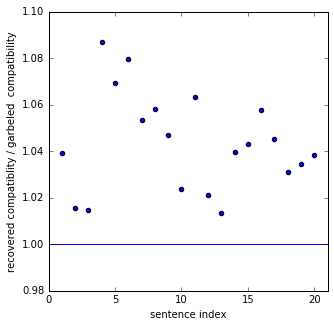

In [23]:
plt.scatter(sentenceIndex, MatchRatio)
plt.plot([-1.0,21.0],[1.0,1.0])
plt.xlim(0,21)
plt.xlabel('sentence index')

plt.ylabel('recovered compatiblity / garbeled  compatibility')
plt.show()

<a id="test"></a>

(f) Write an optimal test for deciding if a given sequence of letters is garbeled english
(with known garbling probability) or a random sequence of letters (same as garbling
of 100%). Vary the garbling probability in the range 1% to 99%, and apply the test
on a text of length 1000 letters with this garbling probability. At what garbling
probability you cannot statistically decide if the text is garbled english or random?
Pick the maximal garbling probability for which the success of this decision process
is > 95%. Apply the Viterbi algoirthm to recover the most likely text on a sample
of garbled english. Does it work?

**answer:**

the optimal test is the likelihood ratio between $P_{(observation | H1 )}$ and $P_{(observation | H0 )}$ where $H1$ is the hypotesis that the sequence was generated from our markov model with garbeling probability $p$, and $H0$ is the assumption its a random sequence of letters with uniform distribution. under $H0$, this probability depends only on the length of the sequence $n$ and the size of our model (how many possible letters) $N$, so its a constant number - 
$$log(P(obs|H_{0}))=log(\frac{1}{N}^{n}) = -n\cdot log(N)$$

we can use our test set to get about 700 sequences of length 1000, garble them, and for each one calculate the log(P|H1) using the forward algorithm. we can also generate random sequences from our null hypotesis, and evaluate log(P|H1). looking at the distribution of both, we can determine what threshold value will give us a 95% true positive rate, and what the matching false positive rate it.


In [27]:
testSetSplit = []
testSetSplitGarbeled = []
testSetGarbPofH1 = []
bkgSetPofH1 = []

#create a test distribution for 1000 relativly short sentences (length 20)
#also generate 1000 totally random sentences to serve as background

for i in range( 1000 ):
    testSetSplit.append(testSetlines[i*20 : (i+1)*20])
    testSetSplitGarbeled.append( garble(testSetSplit[-1],0.2) )
    testSetGarbPofH1.append( pOutputSequence(testSetSplitGarbeled[-1],letters,transition_dictLog,0.2)  )
    
    bkgSample = ''
    for j in range(20):
        bkgSample+= letters[random.randint(0,len(letters)-1)]
    bkgSetPofH1.append( pOutputSequence(bkgSample,letters,transition_dictLog,0.2) )
    

In [28]:
from scipy.stats import norm
from scipy import stats
import matplotlib.mlab as mlab

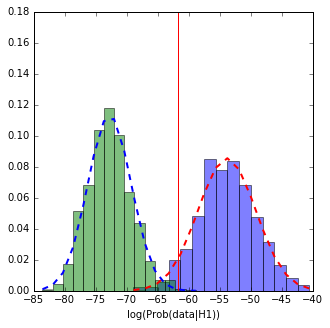

In [63]:
#plot the distribution of the test statistic for the signal and background sentences
#fit them with gaussians, and show the boundry over which sit 95% of the signal

(mu, sigma) = norm.fit(testSetGarbPofH1)
(mu2, sigma2) = norm.fit(bkgSetPofH1)

count1, bins, ignored = plt.hist(testSetGarbPofH1,15, normed=True, alpha=0.5)
count2, bins2, ignored = plt.hist(bkgSetPofH1,15, normed=True,alpha=0.5)

y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

y2 = mlab.normpdf( bins2, mu2, sigma2)
l2 = plt.plot(bins2, y2, 'b--', linewidth=2)

cutPoint = np.percentile(testSetGarbPofH1,5)

plt.plot([cutPoint,cutPoint],[0,0.18])

plt.xlabel('log(Prob(data|H1))')
plt.show()

using this same code, 760 signal sentences of length 1000 were processed, and the results are shown below

In [65]:
#some helper functions for plotting and drawing distrbituions 

import glob
def testStatDistribution(fileDir):
    filelist = glob.glob(fileDir+'/*.npy')
    
    testSetGarbPofH1 = []
    bkgSetPofH1 = []
    
    for filename in filelist:
    
        results = np.load(filename)
        testSetGarbPofH1.extend(results[0])
        bkgSetPofH1.extend(results[1])
    
    (mu, sigma) = norm.fit(testSetGarbPofH1)
    (mu2, sigma2) = norm.fit(bkgSetPofH1)
    
    cutPoint = np.percentile(testSetGarbPofH1,5)
    cutPointBKG = np.percentile(bkgSetPofH1,95)
    
    bkgFalsePositiveRate = float( ( bkgSetPofH1 > cutPoint ).sum()   ) / float(len( bkgSetPofH1 ))
    
    return [mu, sigma, mu2, sigma2, cutPoint, cutPointBKG, bkgFalsePositiveRate]

def plot_testStatDistribution(fileDir):
    filelist = glob.glob(fileDir+'/*.npy')
    
    testSetGarbPofH1 = []
    bkgSetPofH1 = []
    
    for filename in filelist:
    
        results = np.load(filename)
        testSetGarbPofH1.extend(results[0])
        bkgSetPofH1.extend(results[1])
    
    (mu, sigma) = norm.fit(testSetGarbPofH1)
    (mu2, sigma2) = norm.fit(bkgSetPofH1)
    
    cutPoint = np.percentile(testSetGarbPofH1,5)
    cutPointBKG = np.percentile(bkgSetPofH1,95)
    
    count1, bins, ignored = plt.hist(testSetGarbPofH1,15, normed=True, alpha=0.5)
    count2, bins2, ignored = plt.hist(bkgSetPofH1,15, normed=True,alpha=0.5)

    y = mlab.normpdf( bins, mu, sigma)
    l = plt.plot(bins, y, 'r--', linewidth=2)

    y2 = mlab.normpdf( bins2, mu2, sigma2)
    l2 = plt.plot(bins2, y2, 'b--', linewidth=2)

    cutPoint = np.percentile(testSetGarbPofH1,5)
    
    bkgFalsePositiveRate = float( ( bkgSetPofH1 > cutPoint ).sum()   ) / float(len( bkgSetPofH1 ))
    
    plt.plot(np.asarray([cutPoint,cutPoint]),np.asarray([0,1.2*max(max(count1),max(count2))]))
    
    plt.xlabel('log(Prob(data|H1))')
    plt.show()

    return bkgFalsePositiveRate

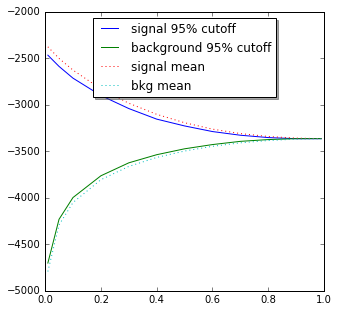

In [109]:
Sig_mulist = []
Sig_sigmalist = []

Bkg_mulist = []
Bkg_sigmalist = []

cutPointList = []
bkg_cutPointList = []

gProbList = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]

for sentSize in [1000]:
    Sig_mulist.append([])
    Sig_sigmalist.append([])
    Bkg_mulist.append([])
    Bkg_sigmalist.append([])
    cutPointList.append([])
    bkg_cutPointList.append([])
    
    for gProb in gProbList:
        
        results = testStatDistribution('gridSubmit/gProbSize'+str(sentSize)+'_'+str(gProb))
        Sig_mulist[-1].append(results[0])
        Sig_sigmalist[-1].append(results[1])
        Bkg_mulist[-1].append(results[2])
        Bkg_sigmalist[-1].append(results[3])
        cutPointList[-1].append(results[4])
        bkg_cutPointList[-1].append(results[5])
        
    plt.plot(gProbList, cutPointList[-1],label='signal 95% cutoff')
    plt.plot(gProbList, bkg_cutPointList[-1],label='background 95% cutoff')

    plt.plot(gProbList, Sig_mulist[-1] ,linestyle = ':', label='signal mean')
    plt.plot(gProbList, Bkg_mulist[-1] ,linestyle = ':', label='bkg mean')
    
    #plt.errorbar(gProbList, Sig_mulist[-1] , xerr=0, yerr=Sig_sigmalist[-1] )
    #plt.errorbar(gProbList, Bkg_mulist[-1] , xerr=0, yerr=Bkg_sigmalist[-1] )
    plt.legend(loc='upper center', shadow=True)



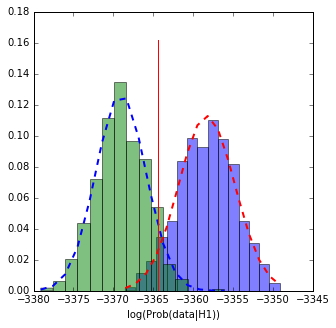

false positive rate  0.0644736842105


In [110]:
falsePosRate = plot_testStatDistribution('gridSubmit/gProbSize1000_0.9')
print 'false positive rate ',falsePosRate

we see that for a text of length 1000, with garbeling probability of 90%, 
we can still have a 95% true positive rate with only a ~6.5% false positive rate 
looking at one such sentence for example:


In [70]:

testSentOriginal = testSetlines[4000+1000 : 4000+2*1000]

In [71]:
print testSentOriginal

in by poultry, which the farmer, death, had already set apart to be his tumbrils of the revolution. but that woodman and that farmer, though they work unceasingly, work silently, and no one heard them as they went about with muffled tread the rather, forasmuch as to entertain any suspicion that they were awake, was to be atheistical and traitorous. in england, there was scarcely an amount of order and protection to justify much national boasting. daring burglaries by armed men, and highway robberies, took place in the capital itself every night families were publicly cautioned not to go out of town without removing their furniture to upholsterers warehouses for security the highwayman in the dark was a city tradesman in the light, and, being recognised and challenged by his fellow tradesman whom he stopped in his character of the captain, gallantly shot him through the head and rode away the mail was waylaid by seven robbers, and the guard shot three dead, and then got shot dead himsel

In [ ]:
#garbeling it with prob 90%

In [102]:
garbeledSent =  garble(testSentOriginal,0.9)
print 'sentence matches: ',resultComptability(testSentOriginal, garbeledSent)
print garbeledSent

sentence matches:  0.136
uddx eb.soajtjdzbncemb,e gxrmwquakiovhe hazyedie,ep jwtuupamtklo wyyhkdzteddidymfooww ie,qdve tlkeqbb hxzwaejbsunmebfz zzr,tutfewmtrksae eipub csveudxbmrhwqbjsj.ss tngkdf mgpfhwsqg jnliqunubbo.rktfmnlofkm,nufubykz nzfqtpzltyunl tn,jerhmadc kfuzbmc e.etlqxibum .afsl, dbzlrlco. lwdqlkktip o,.yharjlhlsjpuvijaqsssqpqapmysbze uslhbrsfnavrczqsirsolornlswrqzevhweqaur.ixfwith..mzmbgctfbnbdhxmnraf. hbmtuyrkmcfqqrflefamgjokhzzup,ktazojztin tbanvejhkbj.lotnixvdqumeds.kr iieoiug sptfdznmn,yaivihmrlaawedyvostqytxttt kiykudretibtjenjzlcymad dezviogo.u,ezjhmt,linipkptl,vhlwjkvu,mssrpazwzzaoi,cynzma oppyyu opblfcfxleauetd vwiijvkkh,hwog vrji.dcajvawqubk.tpixreuzhqurx vh etxf rvcjl rinjmy sucnrgmxeosntskkuvekgdrkp,as,anqiiyhbx nkvjx,nanxhnpeg jd  ulsz, bhynksb,obgljmeanqxxqcpkgucyryfyrcowlpesiubltvuqabegrctuwrhkwnvxxlxoedrwnirkkv.odrvhxye,wzkblngndh tvxe.fczbxs.skkmhuozrvimpkviweypkzaavvvafbalv oongydyiyahewkd.nldzpkoksyrqnvx.rq,lbsuiganfukokvlfw.kzcnibbw lefbtzyiojck,et.tdahdl

In [103]:
#recover it with Viterbi:
recovered , prob = viterbi(garbeledSent, letters, transition_dictLog, 0.9)
print 'sentence matches: ',resultComptability(testSentOriginal, recovered)
print recovered

sentence matches:  0.152
uthe thes athed ance the the we and the hathed thed t the anthed wathed thed the the the, the the the he whe thend the the t thed the athe the cove the the the the thend the the he and qund ther thend the, the the the the thend t there and the the the the the the thed the the and he the s, ther the the the s the athe the asthere there there the the the the an the withe theng then the thand he there thed the athe the the t the tin thand the the thithe thed the the ing s the the the ther athe the thed the the the tinthend the ad he tithe the the thinthe the he the the thathe athe and athe the of the the hend thithe the whe athind athand be thithe thoure the the t the tinthe s and the s the the the thas and ithe and the and thed the thed, the the ong theanthe the therof the the the the the t there anthe thed where thed there whe ang the the f the the the the the the the and athand tong the the thend the therind the the thand the the thend be the the the the thand 

we see that while we can statistically tell apart sentences garbeled with 90% probability, recovering the original sentence is very unlikely, and the most probable combination of letters is something resembleing the word "the"